### **Importing the libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### **Loading the dataset**

In [2]:
data = pd.read_csv('credit_prediction.csv')

#### **Explantory Data Analysis - EDA**

##### **Extracting info about the dataset**

In [ ]:
data.head()

In [ ]:
data.tail()

In [ ]:
# looking at the types data in the dataset
data.dtypes

##### **Geeting the unique values of each categorical variable**

In [ ]:
data.Occupation.unique()

In [ ]:
data.Type_of_Loan.unique()

In [ ]:
data.Credit_Mix.unique()

In [ ]:
data.Payment_of_Min_Amount.unique()

In [ ]:
data.Payment_Behaviour.unique()

In [ ]:
data.Credit_Score.unique()

In [4]:
# storing the categorical variables using a list comprehension for later use
categorical_data = [x for x in data.columns if data[x].dtypes == object]

In [ ]:
# looking at the description of the dataset
data.describe()

##### **Imputing missing values and cleaning up the dataset**

In [5]:
def remove_NaN(df):
   
   categorical_columns = list(df.select_dtypes(include = object))
   numeric_columns = list(df.select_dtypes(exclude = object))
   
   df_categorical = df[categorical_data].fillna('')
   df_numeric = df[numeric_columns].fillna(0)
   
   return df_numeric.join(df_categorical)

data_clean = remove_NaN(data)

#### **EDA - Plots and Graphs**

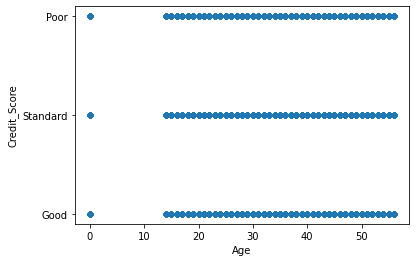

In [51]:
# looking at the plot, we can see that Age doesn't afect credit score that much
data_clean.plot.scatter(x = 'Age', y = 'Credit_Score')

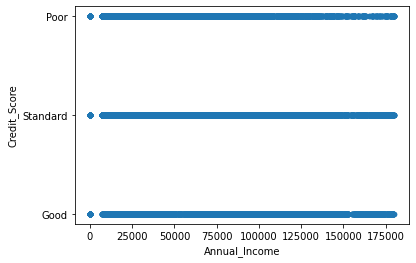

In [36]:
# looking at the plot, we can see that Annual income doesn't mean you would have a good credit score 
data_clean.plot.scatter(x = 'Annual_Income', y = 'Credit_Score')

#### **Preprocessing the categorical variables**

In [6]:
from sklearn.preprocessing import LabelEncoder

def preprocess_categorical_columns(data, categorical_columns, suffix = '_encoded'):
   
   categorical_data = data[categorical_columns].astype(str)
   
   encoder = LabelEncoder()
   
   categorical_data_encoded = categorical_data.apply(encoder.fit_transform)
   data_processed = data.join(categorical_data_encoded, rsuffix = suffix)
    
   return data_processed


data_ready = preprocess_categorical_columns(data_clean, [x for x in data_clean.columns if data_clean[x].dtypes == object])

In [7]:
data_ready = data_ready.drop(columns = list(data_ready.select_dtypes(include = object)))

data_ready.head()

,id,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Monthly_Balance,Occupation_encoded,Type_of_Loan_encoded,Credit_Mix_encoded,Payment_of_Min_Amount_encoded,Payment_Behaviour_encoded,Credit_Score_encoded
0,0,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,26.822620,265.0,80.415295,312.494089,13,129,2,2,0,0
1,1,23.0,0.00,1824.843333,3.0,4.0,3.0,4.0,-1.0,4.0,...,0.000000,266.0,118.280222,284.629162,13,129,2,2,4,0
2,2,23.0,19114.12,1824.843333,3.0,4.0,3.0,0.0,3.0,7.0,...,28.609352,267.0,81.699521,331.209863,13,129,2,2,5,0
3,3,23.0,19114.12,1824.843333,0.0,4.0,3.0,4.0,5.0,4.0,...,31.377862,268.0,199.458074,223.451310,13,129,2,2,6,0
4,4,23.0,19114.12,1824.843333,3.0,4.0,3.0,4.0,0.0,4.0,...,24.797347,269.0,41.420153,341.489231,0,129,2,2,2,0


#### **Generating Train, Test, and Validation Sets**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer


def generate_sets(dataframe, target_column, train_size, test_size):
   
   X = dataframe.drop(columns = [target_column])
   y = dataframe[target_column]
   
   x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_size, train_size = train_size, random_state = 42)
   x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)
   
   # bin the credit score into 3 classes
   discretizer = KBinsDiscretizer(n_bins = 3, encode = 'ordinal')
   y_train = discretizer.fit_transform(y_train.values.reshape(-1, 1))
   y_test = discretizer.transform(y_test.values.reshape(-1, 1))
   y_val = discretizer.transform(y_val.values.reshape(-1, 1))
   
   scalar_x = StandardScaler()
   X_train = scalar_x.fit_transform(x_train)
   X_test = scalar_x.transform(x_test)
   X_val = scalar_x.transform(x_val)
   
   return X_train, X_test, X_val, y_train, y_test, y_val


X_train, X_test, X_val, y_train, y_test, y_val = generate_sets(data_ready, 'Credit_Score_encoded', 0.8, 0.2)

##### **Building the Model with Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [60]:
print(f'Model Accuracy: {round(model.score(X_val, y_val) * 100)}%')

Model Accuracy: 89%


##### **Hyperparameter Tuning with 10 Fold Cross Validation**

In [61]:
from sklearn.model_selection import RandomizedSearchCV

def tune_model(X_train, y_train, model, param_distributions, n_iter):
   # define the RandomSearchCV object
   search = RandomizedSearchCV(model, param_distributions, cv = 10, n_iter = n_iter)
    
   # fit the model
   search.fit(X_train, y_train)
    
   # print the best parameters found
   print(f"Best parameters: {search.best_params_}")
    
   # print the best score achieved
   print(f"Best score: {search.best_score_}")
    
   # return the best estimator
   return search.best_estimator_


# define the parameter distributions to sample from
param_distributions = {'n_estimators': [10, 50, 100, 200, 500],
                       'max_depth': [None, 5, 10, 20],
                       'min_samples_split': [2, 5, 10]}

# call the function to tune the model
best_model = tune_model(X_train, y_train, model, param_distributions, 10)

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}
Best score: 0.8932166666666668


In [62]:
# fit the best model to the training data
best_model.fit(X_train, y_train)

# predict the labels for the test data
y_pred = best_model.predict(X_test)

# compute the accuracy of the model
accuracy = best_model.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


##### **Neural Netowrk Classification**

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

def tune_model(X_train, y_train, model, param_distributions, n_iter):
   # define the RandomSearchCV object
   search = RandomizedSearchCV(model, param_distributions, cv = 10, n_iter = n_iter, random_state = 42, n_jobs = -1)
    
   # fit the model
   search.fit(X_train, y_train)
    
   # print the best parameters found
   print(f"Best parameters: {search.best_params_}")
    
   # print the best score achieved
   print(f"Best score: {search.best_score_}")
    
   # return the best estimator
   return search.best_estimator_

# define the model
model = MLPClassifier(random_state = 42)

# define the parameter distributions to sample from
param_distributions = {'hidden_layer_sizes': [(10,), (50,), (100,), (200,), (500,)],
                       'activation': ['identity', 'logistic', 'tanh', 'relu']}

# call the function to tune the model
best_model = tune_model(X_train, y_train, model, param_distributions, 10)

Best parameters: {'hidden_layer_sizes': (100,), 'activation': 'logistic'}
Best score: 0.8471666666666666


In [24]:
# fit the best model to the training data
best_model.fit(X_train, y_train)

# predict the labels for the test data
y_pred = best_model.predict(X_test)

# compute the accuracy of the model
accuracy = best_model.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.84


##### **AdaBoost Classifier**

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier

def tune_model(X_train, y_train, model, param_distributions, n_iter):
   # define the RandomSearchCV object
   search = RandomizedSearchCV(model, param_distributions, cv = 10, n_iter = n_iter, random_state = 42, n_jobs = -1)
    
   # fit the model
   search.fit(X_train, y_train)
    
   # print the best parameters found
   print(f"Best parameters: {search.best_params_}")
    
   # print the best score achieved
   print(f"Best score: {search.best_score_}")
    
   # return the best estimator
   return search.best_estimator_

# define the model
model = AdaBoostClassifier(random_state = 42)

# define the parameter distributions to sample from
param_distributions = {'n_estimators': [50, 100, 200, 500],
                       'learning_rate': [0.1, 1, 10]}

# call the function to tune the model
best_model_Ada = tune_model(X_train, y_train, model, param_distributions, 10)

Best parameters: {'n_estimators': 500, 'learning_rate': 1}
Best score: 0.8512666666666668


In [26]:
# fit the best model to the training data
best_model_Ada.fit(X_train, y_train)

# predict the labels for the test data
y_pred = best_model_Ada.predict(X_test)

# compute the accuracy of the model
accuracy = best_model_Ada.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


##### **Choosing the right independant variables**

In [70]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# define the number of features to keep
num_features_to_keep = 5

# define the feature selection method
# you can use mutual_info_classif or f_classif
fs = mutual_info_classif

# define the SelectKBest object
selector = SelectKBest(fs, k = num_features_to_keep)

# fit the SelectKBest object to the training data
selector.fit(X_train, y_train)

# select the top num_features_to_keep features
X_train_pruned = selector.transform(X_train)
X_test_pruned = selector.transform(X_test)

# define the model
model = RandomForestClassifier(n_jobs = -1, random_state = 42)

# fit the model to the pruned training data
model.fit(X_train_pruned, y_train)

# predict the labels for the pruned test data
y_pred = model.predict(X_test_pruned)

# compute the accuracy of the model on the pruned test data
accuracy = model.score(X_test_pruned, y_test)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


In [65]:
# fit the best model to the training data
best_model.fit(X_train_pruned, y_train)

# predict the labels for the test data
y_pred = best_model.predict(X_test_pruned)

# compute the accuracy of the model
accuracy = best_model.score(X_test_pruned, y_test)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [66]:
# fit the best model to the training data
best_model_Ada.fit(X_train, y_train)

# predict the labels for the test data
y_pred = best_model_Ada.predict(X_test)

# compute the accuracy of the model
accuracy = best_model_Ada.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85
